# Global definitions

Load Pylab, define CPTs...
$P(o^0) = P(p^0) \cdot P(p^0)$

In [29]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [30]:
# Define the CPTs and other useful functions here (e.g. samling from a distribution) here...
POB = array([[[0.01, 0.7], 
               [0.99, 0.3] ],
            [[0.8, 0.999],
            [0.2, 0.001]]])
O_PB = POB.transpose(1, 0, 2)
T_P = array([[0.8, 0.1],
             [0.2, 0.9]])
P_L = T_P.copy()  #copy array and not reference 
L = array([0.9, 0.1])
B = array([0.99, 0.01])

#T = empty([1, 2])
O = L.copy()
#P = empty([1, 2])

P = (P_L * L).sum(1)
T = (T_P * P).sum(1)
O[0] = P[0] * B[0] * O_PB[0, 0, 0] + P[1] * B[0] * O_PB[0, 1, 0] + P[0] * B[1] * O_PB[0, 0, 1] + P[1] * B[1] * O_PB[0, 1, 1]
O[1] = P[0] * B[0] * O_PB[1, 0, 0] + P[1] * B[0] * O_PB[1, 1, 0] + P[0] * B[1] * O_PB[1, 0, 1] + P[1] * B[1] * O_PB[1, 1, 1]

# 1) Approximate Inference Algorithms

Approximate $P(E\mid M, S)$ using various techniques.

## A) Rejection Sampling

In [46]:
global L_TO_rs
def approx_rs(t, o, n):
    """ 
    Approximates P(L | T, O) using rejection sampling
    :param t: given value for T
    :param o: given value for O
    :param n: number of samples to use
    :returns: Numpy array containing the approximated distribution
    """
    # TODO: implement this function
    
    counter = 0.0
    counter2 = 0.0
    
    for x in range(n):
        tra = random.randint(0, 2)  #position, not value
        ora = random.randint(0, 2)  #position, not value
        
        if (tra == t and ora == o) :
            counter2 += 1.0
            lra = L.cumsum().searchsorted(random.sample(1))[0]  #position, not value
            if lra == 0 :
                counter += 1.0
    
    if counter2 == 0.0:
        l0_TO = 0.0
    else:
        l0_TO = counter / counter2
    
    return array([l0_TO, 1 - l0_TO])

L_TO_rs = approx_rs(1, 0, 10000)
print L_TO_rs

[ 0.8994391  0.1005609]


## B) Likelihood Weighting

In [32]:
def approx_lw(t, o, n):
    """
    Empty implementation of Aiv)
    Approximates P(L | T, O) using likelihood weighting
    :param t: given value for T
    :param o: given value for O
    :param n: number of samples to use
    :returns: Numpy array containing the approximated distribution
    """
    # TODO: implement this function
    l0 = 0.0
    l1 = 0.0
    
    for x in range(n):
        bx = random.sample(1)
        px = random.sample(1)  
        bra = B.cumsum().searchsorted(bx)[0]  #position, not value
        pra = P.cumsum().searchsorted(px)[0]  #position, not value
        l0 += P_L[pra, 0] * T_P[t, pra] * O_PB[o, pra, bra]
        l1 += P_L[pra, 1] * T_P[t, pra] * O_PB[o, pra, bra]
    
    ltot = l0 + l1
    
    return array([l0/ltot, l1/ltot])

## C) Gibbs Sampling

In [33]:
def approx_gibbs(t, o, n):
    """ 
    Approximates P(L | T, O) using Gibbs sampling
    :param t: given value for T
    :param o: given value for O
    :param n: number of samples to use
    :returns: Numpy array containing the approximated distribution
    """
    # TODO: implement this function
    lx = random.sample(1)
    bx = random.sample(1)
    px = random.sample(1)
    lra = L.cumsum().searchsorted(lx)[0]  #position, not value
    bra = B.cumsum().searchsorted(bx)[0]  #position, not value
    pra = P.cumsum().searchsorted(px)[0]  #position, not value
    counter = 0.0
    
    for y in range(1, n):
        # 1
        l0_pbto = L[0] * P_L[pra, 0]
        l1_pbto = L[1] * P_L[pra, 1]
        l_pbto_sum = l0_pbto + l1_pbto
        L_pbto = array([l0_pbto / l_pbto_sum, l1_pbto / l_pbto_sum])
        lx2 = random.sample(1)
        lra = L_pbto.cumsum().searchsorted(lx2)[0] 
        # 2    
        p0_lbto = P_L[0, lra] * T_P[t, 0] * O_PB[o, 0, bra]
        p1_lbto = P_L[1, lra] * T_P[t, 1] * O_PB[o, 1, bra]
        p_lbto_sum = p0_lbto + p1_lbto
        P_lbto = array([p0_lbto / p_lbto_sum, p1_lbto / p_lbto_sum])
        px2 = random.sample(1)
        pra = P_lbto.cumsum().searchsorted(px2)[0]
        # 3
        b0_lpto = B[0] * O_PB[o, pra, 0]
        b1_lpto = B[1] * O_PB[o, pra, 1]
        b_lpto_sum = b0_lpto + b1_lpto
        B_lpto = array([b0_lpto / b_lpto_sum, b1_lpto / b_lpto_sum])
        bx2 = random.sample(1)
        bra = B_lpto.cumsum().searchsorted(bx2)[0]
        if lra == 0:
            counter += 1
            
            
    
    l0_TO = counter / n
    
    return array([l0_TO, 1 - l0_TO])

# 2) Comparison

## A) Exact Inference

$P(l^0 | t, o) = \frac{1}{Z} \cdot \sum_{p, b}{P(l^0) \cdot P(p | l^0) \cdot P(b) \cdot P(t | p) \cdot P(o | p, b)}$

$P(l^1 | t, o) = \frac{1}{Z} \cdot \sum_{p, b}{P(l^1) \cdot P(p | l^1) \cdot P(b) \cdot P(t | p) \cdot P(o | p, b)}$

In [34]:
def exact(t, o):
    """ 
    Computes P(L | T, O) using exact inference
    :param t: given value for T
    :param o: given value for O
    :returns: Numpy array containing the distribution
    """
    # TODO: implement this function
    
    l0_to = L[0] * P_L[0, 0] * B[0] * T_P[t, 0] * O_PB[o, 0, 0] + L[0] * P_L[1, 0] * B[0] * T_P[t, 1] * O_PB[o, 1, 0] + L[0] * P_L[0, 0] * B[1] * T_P[t, 0] * O_PB[o, 0, 1] + L[0] * P_L[1, 0] * B[1] * T_P[t, 1] * O_PB[o, 1, 1]    
        
    l1_to = L[1] * P_L[0, 1] * B[0] * T_P[t, 0] * O_PB[o, 0, 0] + L[1] * P_L[1, 1] * B[0] * T_P[t, 1] * O_PB[o, 1, 0] + L[1] * P_L[0, 1] * B[1] * T_P[t, 0] * O_PB[o, 0, 1] + L[1] * P_L[1, 1] * B[1] * T_P[t, 1] * O_PB[o, 1, 1]
      
    lsum = l0_to + l1_to
    
    return array([l0_to / lsum, l1_to / lsum])

## B) Compute and plot estimation errors

In [35]:
def kld(p, q):
    """
    Computes the Kullback-Leibler divergence between p and q.
    :param p: true distribution
    :param q: estimated distribution
    :return: Kullback-Leibler Divergence between p and q
    """
    return (p * np.log(p / (q + 0.00000000001))).sum()  # add a small constant for numeric stability


def compute_approximation_error(approx_function, t, o, n_runs, sample_counts, **kwargs):
    """
    Computes the approximation error for a given approximation method.
    :param approx_function: function used to approximate the distribution
    :param t: given value for T
    :param o: given value for O
    :param n_runs: number of approximations
    :param sample_counts: list or array of numbers of sampels to use
    :returns: mean approximation error for each of the sample counts
    """
    mean_errors = []
    correct = exact(t, o)
    
    for num_samples in sample_counts:
        estimates = array([approx_function(t, o, n=num_samples, **kwargs) for i in range(n_runs)])
        mean_errors.append(abs(estimates - correct).mean())       
        #mean_errors.append(kld(correct, estimates))  # use this instead of the line above for KLD!
    
    return mean_errors

### Compute the estimation errors


In [38]:
rs_errs = {}
lw_errs = {}
gb_errs = {}
n_runs = 100
sample_counts = array([10, 20, 40, 80, 160, 320, 640, 1280])

for t, o in zip([0, 0, 1, 1], [0, 1, 0, 1]):
    rs_errs[(t, o)] = compute_approximation_error(approx_rs, t, o, n_runs, sample_counts)
    lw_errs[(t, o)] = compute_approximation_error(approx_lw, t, o, n_runs, sample_counts)
    gb_errs[(t, o)] = compute_approximation_error(approx_gibbs, t, o, n_runs, sample_counts)

### Plot the estimation errors

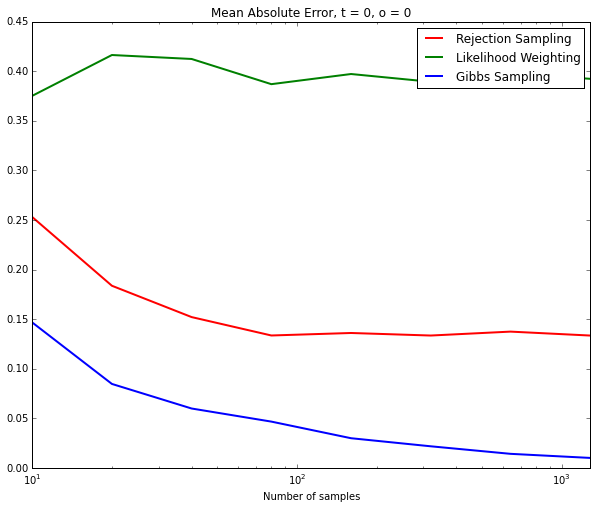

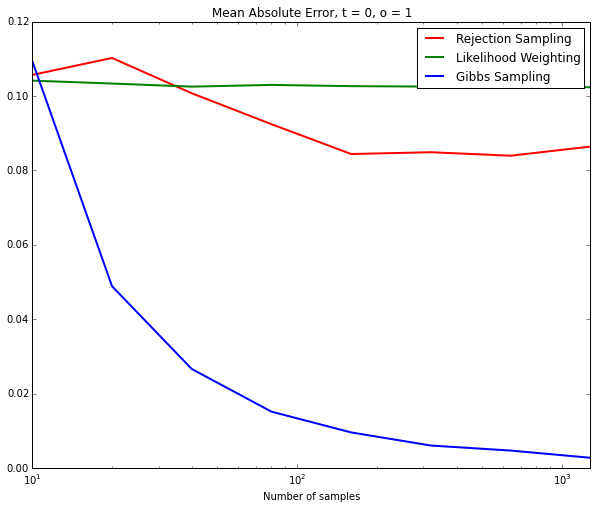

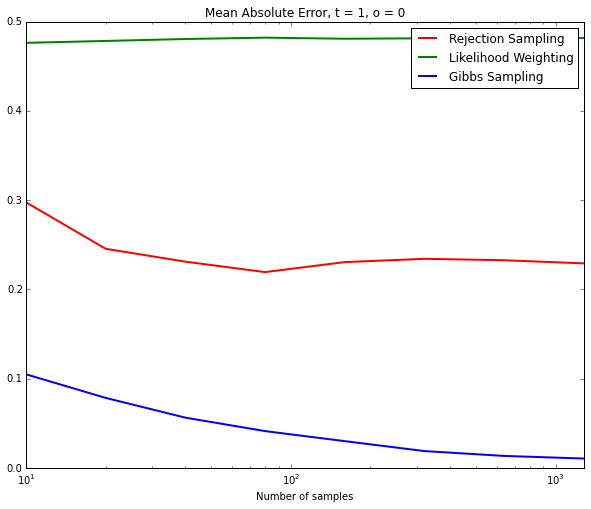

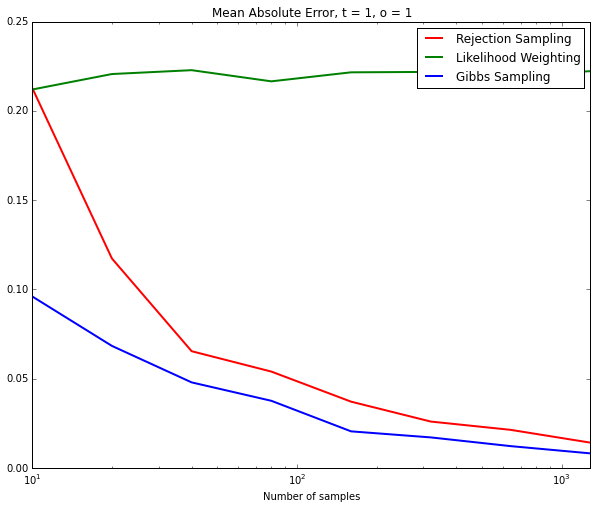

In [39]:
for t, o in zip([0, 0, 1, 1], [0, 1, 0, 1]):
    figure(figsize=(10, 8))
    title('Mean Absolute Error, t = %d, o = %d' % (t, o))

    plot(sample_counts, rs_errs[(t, o)], 'r', label='Rejection Sampling', lw=2)
    plot(sample_counts, lw_errs[(t, o)], 'g', label='Likelihood Weighting', lw=2)
    plot(sample_counts, gb_errs[(t, o)], 'b', label='Gibbs Sampling', lw=2)   
    
    legend()
    xscale('log')
    xlim(sample_counts.min(), sample_counts.max())
    xlabel('Number of samples')

In [12]:
approx_rs(0, 0, 10)
approx_lw(0, 0, 10)
approx_gibbs(0, 0, 10)
exact(0,0)

[ 0.4  0.6]


array([ 0.7667407,  0.2332593])